In [1]:
import loompy

In [138]:
import tables as tb

In [160]:
import matplotlib.pyplot as plt

In [161]:
import seaborn as sns

In [139]:
fileh = tb.open_file('../data/single-cell/zeisel_2018/l5_all.agg.loom',mode='r')

In [140]:
fileh.root

/ (RootGroup) ''
  children := ['attrs' (Group), 'col_attrs' (Group), 'col_graphs' (Group), 'layers' (Group), 'row_attrs' (Group), 'row_graphs' (Group), 'matrix' (EArray)]

In [2]:
agg = loompy.connect('../data/single-cell/zeisel_2018/l5_all.agg.loom')

In [271]:
agg.close()

In [3]:
agg.shape

(27998, 265)

This matrix stores the expression level of 27998 "genes" in 265 "clusters". 

In [133]:
agg[0:2,0:2]

array([[13.97633136,  0.42268041],
       [ 0.39053254,  0.        ]])

In [137]:
agg.layers.keys()

['', 'enrichment', 'enrichment_q', 'trinaries', 'trinaries_0.05']

In [147]:
# estimate wether a gene is expressed, not expressed, or unknown
agg.layers['trinaries'][0:2,0:2]

array([[1.00000000e+00, 7.06841243e-01],
       [9.99817775e-01, 1.30853550e-09]])

In [158]:
tri_arr = agg.layers['trinaries'][:,:]

In [215]:
tri_arr.shape

(27998, 265)

In [230]:
agg.layers.keys()

['', 'enrichment', 'enrichment_q', 'trinaries', 'trinaries_0.05']

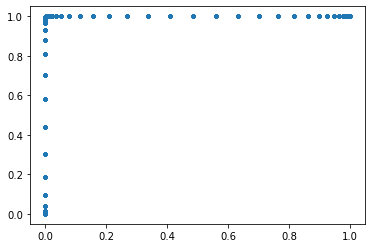

In [241]:
plt.plot(agg['trinaries'][0:10000,0].tolist(),agg['trinaries_0.05'][0:10000,0].tolist(),'.')

The above fig shows that when trinaries score is near 1, trinaries_0.05 must be near 1 as well; when trinaries score is near 0, it is still possible to have trinaries_0.05 scores near 1. That is, it is much harder to make a expressed call at the trinaries condition than the trinaries_0.05 condition. I think trinaries scores are recorded at f=0.2, aka, trinarization based on whether more than 20% of cells in the population expressed the gene; trinaries_0.05 scores are recorded at f=0.05, aka, thether more than 5% of cells in the population expressed the gene. 

In [252]:
type(agg['trinaries'][0,0])

numpy.float64

In [242]:
agg['trinaries_0.05'][:,:].min()

-2.9103830456733704e-11

In [243]:
agg['trinaries_0.05'][:,:].max()

1.0

In [244]:
agg['trinaries'][:,:].min()

-4.3655745685100555e-11

In [247]:
agg['trinaries'][:,:].max()

1.0

In [218]:
agg['trinaries'].shape

(27998, 265)

In [221]:
(agg.ca["TaxonomyRank1"] == 'Glia').shape

(265,)

In [223]:
agg['trinaries'][:,agg.ca["TaxonomyRank1"] == 'Glia'].shape

(27998, 36)

In [224]:
np.all(agg['trinaries'][:,agg.ca["TaxonomyRank1"] == 'Glia']>0.999, axis=1).shape

(27998,)

In [226]:
np.all(agg['trinaries'][:,agg.ca["TaxonomyRank1"] == 'Glia']>0.999, axis=1)

array([False, False, False, ..., False, False, False])

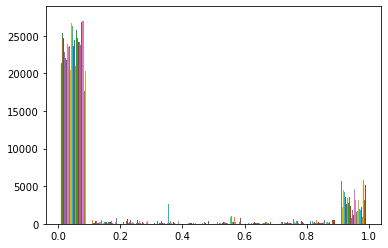

In [163]:
n, bins, patches = plt.hist(tri_arr)
plt.show()

In [253]:
(tri_arr>0.999).sum()

584664

In [254]:
(tri_arr>0.9).sum()

766436

In [255]:
(tri_arr==1).sum()

299013

In [149]:
# posterior error probability PEP=0.05
# less than 5% risk, given the observations, that the expressed call is wrong. 
# f set at 0.2, aka a gene considered expressed in that cluster 
# when PEP<= 0.05 in at least 20% of the cells
agg.layers['trinaries_0.05'][0:2,0:2]

array([[1.        , 1.        ],
       [1.        , 0.01708425]])

In [153]:
(min_tri,max_tri)=agg.map([np.min,np.max],axis=1)

In [155]:
np.max(min_tri)

0.0

In [156]:
np.min(max_tri)

46.64779874213836

In [157]:
np.max(max_tri)

1442.0714285714287

In [150]:
agg.layers['trinaries_0.05']

In [180]:
triq_arr = agg.layers['trinaries_0.05'][:,:]

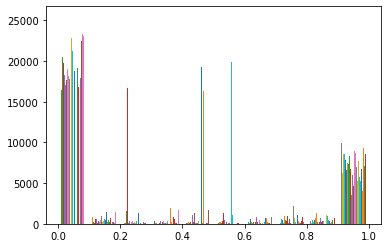

In [181]:
n, bins, patches = plt.hist(triq_arr)
plt.show()

In [148]:
# Enrichment scores. Explained in the paper's method section. 
# 
agg.layers['enrichment'][0:2,0:2]

array([[9.42361034e+02, 7.89783893e+00],
       [3.62833219e+01, 2.16116774e-01]])

In [151]:
# Enrichment q value; e.g., find genes enriched at 10% false discovery rate: q<0.1
agg.layers['enrichment_q'][0:2,0:2]

array([[0.00000000e+00, 7.38552437e-04],
       [0.00000000e+00, 1.00000000e+00]])

In [7]:
# global atributes
agg.attrs.keys()

['CreationDate', 'LOOM_SPEC_VERSION']

In [8]:
agg.attrs.CreationDate

'20210503T185459.559991Z'

In [9]:
agg.attrs.LOOM_SPEC_VERSION

'3.0.0'

In [13]:
# column attributes
len(agg.ca.keys())

214

In [14]:
# row attributes
len(agg.ra.keys())

7

In [33]:
agg.ra.keys()

['Accession', 'Gene', '_LogCV', '_LogMean', '_Selected', '_Total', '_Valid']

In [256]:
np.unique(agg.ra['_Valid'], return_counts=True)

(array([0, 1]), array([ 7195, 20803]))

Of all the rows, 20,803 are valid, while 7,195 are not. 
Based on extract_L6.py, a gene is valid when it has non-zero expression in more than 10 clusters but less than 60% of clusters. I don't think we need to be restricted to the "valid" genes. 

In [259]:
np.unique(agg.ra['Gene'][(agg.ra['_Valid']==1)]).shape

(20788,)

There are genes with more than one rows, and it is not due to validation. 

In [260]:
np.unique(agg.ra['_Selected'], return_counts=True)

(array([0, 1]), array([27518,   480]))

In [179]:
np.unique(agg.ca['Class'])

array(['Astrocytes', 'Ependymal', 'Immune', 'Neurons', 'Oligos',
       'PeripheralGlia', 'Vascular'], dtype=object)

In [168]:
np.unique(agg.ca['TaxonomyRank1'])

array(['Glia', 'Immune cells', 'Neurons', 'Vascular cells'], dtype=object)

In [176]:
Glia = (agg.ca['TaxonomyRank1']=='Glia')

In [190]:
(np.mean(triq_arr[:, Glia], axis=1) == 1).shape 

(27998,)

In [204]:
agg.ra['Gene'][(np.mean(triq_arr[:, Glia], axis=1) == 1)].shape

(232,)

In [208]:
agg.ra['Gene'][(np.mean(triq_arr[:, Glia], axis=1) >= 0.9999)].shape

(938,)

In [213]:
np.mean(triq_arr[:, Glia], axis=1)

array([0.06999371, 0.15274882, 0.09693057, ..., 0.80813442, 0.42613847,
       0.86605659])

In [214]:
np.mean(tri_arr[:, Glia], axis=1)

array([7.04397782e-05, 2.78475716e-02, 7.02547353e-05, ...,
       1.97633446e-01, 2.96955857e-02, 2.71250402e-01])

In [185]:
true_arr=np.array([True, True, True])
false_arr=np.array([False,False,False])
third_arr=np.array([False,True,False])
true_arr & false_arr | third_arr

array([False,  True, False])

In [169]:
np.unique(agg.ca['TaxonomyRank2'])

array(['CNS glia', 'CNS neurons', 'Immune cells',
       'Neural crest-like glia', 'PNS neurons', 'Vascular cells'],
      dtype=object)

In [170]:
np.unique(agg.ca['TaxonomyRank3'])

array(['Astroependymal cells', 'Cerebellum neurons',
       'Cholinergic, monoaminergic and peptidergic neurons',
       'Di- and mesencephalon neurons', 'Enteric neurons',
       'Hindbrain neurons', 'Immature neural', 'Immune cells',
       'Neural crest-like glia', 'Oligodendrocytes',
       'Peripheral sensory neurons', 'Spinal cord neurons',
       'Sympathetic neurons', 'Telencephalon interneurons',
       'Telencephalon projecting neurons', 'Vascular cells'], dtype=object)

In [171]:
np.unique(agg.ca['TaxonomyRank4'])

array(['Astrocytes', 'Cerebellum neurons',
       'Cholinergic and monoaminergic neurons',
       'Choroid epithelial cells', 'Dentate gyrus granule neurons',
       'Dentate gyrus radial glia-like cells',
       'Di- and mesencephalon excitatory neurons',
       'Di- and mesencephalon inhibitory neurons', 'Enteric glia',
       'Enteric neurons', 'Ependymal cells', 'Glutamatergic neuroblasts',
       'Hindbrain neurons', 'Microglia', 'Non-glutamatergic neuroblasts',
       'Olfactory ensheathing cells', 'Olfactory inhibitory neurons',
       'Oligodendrocyte precursor cells', 'Oligodendrocytes',
       'Peptidergic neurons', 'Pericytes',
       'Peripheral sensory neurofilament neurons',
       'Peripheral sensory non-peptidergic neurons',
       'Peripheral sensory peptidergic neurons',
       'Perivascular macrophages', 'Satellite glia', 'Schwann cells',
       'Spinal cord excitatory neurons', 'Spinal cord inhibitory neurons',
       'Subcommissural organ hypendymal cells',
       

In [144]:
np.unique(agg.ca['ClusterName']).shape

(265,)

In [145]:
np.unique(agg.ca['ClusterName'])

array(['ABC', 'ACBG', 'ACMB', 'ACNT1', 'ACNT2', 'ACOB', 'ACTE1', 'ACTE2',
       'CBGRC', 'CBINH1', 'CBINH2', 'CBNBL1', 'CBNBL2', 'CBPC', 'CHOR',
       'COP1', 'COP2', 'CR', 'DECHO1', 'DECHO2', 'DEGLU1', 'DEGLU2',
       'DEGLU3', 'DEGLU4', 'DEGLU5', 'DEINH1', 'DEINH2', 'DEINH3',
       'DEINH4', 'DEINH5', 'DEINH6', 'DEINH7', 'DEINH8', 'DETPH',
       'DGGRC1', 'DGGRC2', 'DGNBL1', 'DGNBL2', 'ENMFB', 'ENT1', 'ENT2',
       'ENT3', 'ENT4', 'ENT5', 'ENT6', 'ENT7', 'ENT8', 'ENT9', 'ENTG1',
       'ENTG2', 'ENTG3', 'ENTG4', 'ENTG5', 'ENTG6', 'ENTG7', 'EPEN',
       'EPMB', 'EPSC', 'HBADR', 'HBCHO1', 'HBCHO2', 'HBCHO3', 'HBCHO4',
       'HBGLU1', 'HBGLU10', 'HBGLU2', 'HBGLU3', 'HBGLU4', 'HBGLU5',
       'HBGLU6', 'HBGLU7', 'HBGLU8', 'HBGLU9', 'HBINH1', 'HBINH2',
       'HBINH3', 'HBINH4', 'HBINH5', 'HBINH6', 'HBINH7', 'HBINH8',
       'HBINH9', 'HBNOR', 'HBSER1', 'HBSER2', 'HBSER3', 'HBSER4',
       'HBSER5', 'HYPEN', 'HYPEP1', 'HYPEP2', 'HYPEP3', 'HYPEP4',
       'HYPEP5', 'HYPEP6', 'HYPEP

### Cleaning data: duplicated genes

In [91]:
len(agg.ra['Gene']) # number of rows; same if replace 'Gene' with 'Accession' or other ra keys

27998

In [71]:
len(np.unique(agg.ra['Accession'])) # number of Accession

27998

In [92]:
len(np.unique(agg.ra['Gene'])) # number of unique gene names

27933

In [93]:
type(agg.ra['Gene'])

numpy.ndarray

In [96]:
agg.ra['Gene'].shape

(27998,)

In [97]:
all_gene_list = agg.ra['Gene'].tolist()

In [99]:
len(all_gene_list)

27998

In [100]:
uniq_gene_set = set(all_gene_list)

In [101]:
type(uniq_gene_set)

set

In [103]:
len(uniq_gene_set)

27933

In [104]:
uniq_gene_list = np.unique(agg.ra['Gene']).tolist()

In [106]:
len(uniq_gene_list) # the same with the set method on list

27933

In [56]:
agg.shape

(27998, 265)

This means there are 27998-27933=65 rows in the agg.loom file with at least one duplicated value in the 'Gene' key attrribute. 

In [108]:
dup_set=set()
for gene in all_gene_list:
    if all_gene_list.count(gene) > 1:
        dup_set.add(gene)

In [111]:
len(dup_set) # the 65 duplicated entries come from 56 gene names

56

In [112]:
dup_list=[]
for gene in all_gene_list:
    if all_gene_list.count(gene) > 1:
        dup_list.append(gene)

In [113]:
len(dup_list)

121

In [118]:
dup_dict={}
for gene in dup_set:
    count=all_gene_list.count(gene)
    dup_dict.update({gene:count})

In [124]:
sum(dup_dict.values())

121

In [125]:
max(dup_dict.values())

7

This means there are 56 gene names with more than 1 entry; each of these gene name has 2 to 7 row corresponding to them. 

In [128]:
# Which gene has 7 entries? 
for gene, count in dup_dict.items():
    if count==7:
        print(gene)

Flg


In [270]:
agg.ra.Accession[agg.ra.Gene=='Flg']

array(['ENSMUSG00000102829', 'ENSMUSG00000103750', 'ENSMUSG00000103777',
       'ENSMUSG00000103335', 'ENSMUSG00000102439', 'ENSMUSG00000102395',
       'ENSMUSG00000102724'], dtype=object)

In [80]:
from collections import Counter

In [85]:
counter = Counter(all_gene_list)
nuniq_gene_list = []
for gene in counter:
    if counter[gene]>1:
        nuniq_gene_list.append(gene)

In [90]:
len(counter)

27933

In [87]:
len(nuniq_gene_list)

56

In [62]:
arr = agg.ra['Gene']
uniq, uniq_idx, counts = np.unique(arr,return_index=True,return_counts=True)
arr_idx = np.arange(arr.shape[0])
nuniq_idx = arr_idx[np.in1d(arr_idx, uniq_idx[counts==1],invert=True)]

In [59]:
np.unique(agg.ra['Gene'],return_index=True,return_counts=True,invert=True)

TypeError: _unique_dispatcher() got an unexpected keyword argument 'invert'

In [65]:
len(agg.ra['Gene'][nuniq_idx][0])

5

In [70]:
np.unique(agg.ra['Gene'][nuniq_idx]).shape

(56,)

In [29]:
import numpy as np
import pandas as pd

In [32]:
np.unique(agg.ca['Class'])

array(['Astrocytes', 'Ependymal', 'Immune', 'Neurons', 'Oligos',
       'PeripheralGlia', 'Vascular'], dtype=object)

In [ ]:
np.unique()

In [21]:
tissue_list=[
    'Tissue_Amygd',
     'Tissue_CA1',
     'Tissue_CB',
     'Tissue_Ctx1',
     'Tissue_Ctx1.5',
     'Tissue_Ctx2',
     'Tissue_Ctx3',
     'Tissue_DRG',
     'Tissue_DentGyr',
     'Tissue_ENS',
     'Tissue_HC',
     'Tissue_Hypoth',
     'Tissue_MBd',
     'Tissue_MBv',
     'Tissue_Medulla',
     'Tissue_OB',
     'Tissue_Pons',
     'Tissue_SC',
     'Tissue_SScortex',
     'Tissue_StriatDor',
     'Tissue_StriatVent',
     'Tissue_Sympath',
     'Tissue_Thal'
]

In [12]:
all_data.ra['Gene']

array(['Cbln2', 'Ptchd2', 'P2rx2', ..., 'Mmadhc', 'Med27', 'Psmc6'],
      dtype=object)

In [13]:
all_data.ra['_LogMean']

array([-2.88649881, -5.5494638 , -3.16173369, ..., -1.39026519,
       -3.06403701, -0.00720581])

In [14]:
hippo=loompy.connect('../data/single-cell/zeisel_2018/hippocampus/l1_hippocampus.loom')

In [15]:
hippo.attrs.keys()

['CreationDate']

In [16]:
hippo.ca.keys()

['Age',
 'AnalysisPool',
 'AnalysisProject',
 'CellConc',
 'CellID',
 'Cell_Conc',
 'ChipID',
 'Class',
 'ClassProbability_Astrocyte',
 'ClassProbability_Astrocyte,Immune',
 'ClassProbability_Astrocyte,Neurons',
 'ClassProbability_Astrocyte,Oligos',
 'ClassProbability_Astrocyte,Vascular',
 'ClassProbability_Bergmann-glia',
 'ClassProbability_Blood',
 'ClassProbability_Blood,Vascular',
 'ClassProbability_Enteric-glia',
 'ClassProbability_Enteric-glia,Cycling',
 'ClassProbability_Ependymal',
 'ClassProbability_Ex-Neurons',
 'ClassProbability_Ex-Vascular',
 'ClassProbability_Immune',
 'ClassProbability_Immune,Neurons',
 'ClassProbability_Immune,Oligos',
 'ClassProbability_Neurons',
 'ClassProbability_Neurons,Cycling',
 'ClassProbability_Neurons,Oligos',
 'ClassProbability_Neurons,Satellite-glia',
 'ClassProbability_Neurons,Vascular',
 'ClassProbability_OEC',
 'ClassProbability_Oligos',
 'ClassProbability_Oligos,Cycling',
 'ClassProbability_Oligos,Vascular',
 'ClassProbability_Satellite-gl

In [17]:
hippo.ra.keys()

['Accession', 'Gene', '_LogCV', '_LogMean', '_Selected', '_Total', '_Valid']

In [20]:
hippo.layers.keys()

['']

In [21]:
import numpy as np
import pandas as pd

In [22]:
hippo_meta_df = pd.read_csv('../data/single-cell/zeisel_2018/hippocampus/meta.tsv',sep='\t')

In [24]:
hippo_meta_df.columns

Index(['cellID', 'Age', 'CellConc', 'Cell_Conc', 'ChipID', 'Class',
       'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune',
       'ClassProbability_Astrocyte,Neurons',
       'ClassProbability_Astrocyte,Oligos',
       'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia',
       'ClassProbability_Blood', 'ClassProbability_Blood,Vascular',
       'ClassProbability_Enteric-glia',
       'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal',
       'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular',
       'ClassProbability_Immune', 'ClassProbability_Immune,Neurons',
       'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons',
       'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos',
       'ClassProbability_Neurons,Satellite-glia',
       'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC',
       'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling',
       'ClassProbability_Oligo

In [26]:
hippo_meta_df['Class'].unique()

array(['Oligos', 'Immune', 'Neurons', 'Vascular', 'Excluded', 'Blood',
       'Astrocytes', 'Ependymal'], dtype=object)

In [28]:
hippo_meta_df['Clusters'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

In [29]:
hippo_meta_df['Subclass'].unique()

array(['Oligos', 'Immune', 'Neurons', 'Vascular', 'Immune,Oligos',
       'Astrocyte,Oligos', 'Oligos,Vascular', 'Neurons,Oligos',
       'Neurons,Cycling', 'Blood', 'Astrocyte', 'Astrocyte,Neurons',
       'Ttr', 'Astrocyte,Vascular', 'OEC', 'Ex-Vascular',
       'Immune,Neurons', 'Neurons,Vascular', 'Astrocyte,Immune',
       'Bergmann-glia', 'Ependymal', 'Oligos,Cycling'], dtype=object)

In [30]:
hippo_meta_df['Tissue'].unique()

array(['HC', 'DentGyr', 'CA1'], dtype=object)

In [31]:
hippo_meta_df['Mean Reads per Cell']

0           761"
1           283"
2           683"
3        149,202
4           761"
          ...   
29488       874"
29489    149,202
29490       417"
29491       874"
29492       683"
Name: Mean Reads per Cell, Length: 29493, dtype: object

In [32]:
hippo_meta_df['Median Genes per Cell']

0          "38
1          "53
2          "57
3        1,111
4          "38
         ...  
29488      "60
29489    1,111
29490      "64
29491      "60
29492      "57
Name: Median Genes per Cell, Length: 29493, dtype: object